# Lecture 2: Professional Data Pipelines with PyTorch

In [2]:
import torch 
import torch.nn as nn 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import time 
from PIL import Image  

#  NEW 
import torchvision 
from torchvision import transforms 
from torch.utils.data import Dataset , DataLoader , IterableDataset
from tqdm import tqdm 

import psutil # for memory monitring 


torch.manual_seed(42) 
np.random.seed(42) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [9]:
print("="*60)
print("THE DATA LOADING CRISIS: GPU vs DATA BOTTLENECK")
print("="*60)

# Create a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Naive data loading function (what most beginners write)
def load_data_naive(batch_size=64):
    """Simulates slow data loading (common mistake)"""
    time.sleep(0.01)  # Simulating disk I/O delay
    return torch.randn(batch_size, 784), torch.randint(0, 10, (batch_size,))

# Simulate training with naive loading
def train_naive(model, num_batches=100):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    
    start_time = time.time()
    gpu_active_time = 0
    
    for batch_idx in range(num_batches):
        # Data loading (slow)
        batch_start = time.time()
        x, y = load_data_naive()
        x, y = x.to(device), y.to(device)
        load_time = time.time() - batch_start
        
        # Forward pass (fast on GPU)
        forward_start = time.time()
        outputs = model(x)
        loss = criterion(outputs, y)
        forward_time = time.time() - forward_start
        
        # Backward pass (fast on GPU)
        backward_start = time.time()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        backward_time = time.time() - backward_start
        
        gpu_active_time += forward_time + backward_time
    
    total_time = time.time() - start_time
    gpu_utilization = (gpu_active_time / total_time) * 100
    
    return total_time, gpu_utilization

# Run the simulation
print("\nSimulating training with naive data loading...")
model = SimpleModel().to(device)
total_time, gpu_util = train_naive(model, num_batches=50)

print(f"\n📊 Results (Naive Loading):")
print(f"Total training time: {total_time:.2f} seconds")
print(f"GPU utilization: {gpu_util:.1f}%")
print(f"GPU idle time: {100 - gpu_util:.1f}%")
print(f"\n💡 Insight: Your GPU is idle {100 - gpu_util:.1f}% of the time!")

THE DATA LOADING CRISIS: GPU vs DATA BOTTLENECK

Simulating training with naive data loading...

📊 Results (Naive Loading):
Total training time: 2.72 seconds
GPU utilization: 79.8%
GPU idle time: 20.2%

💡 Insight: Your GPU is idle 20.2% of the time!


In [11]:
print("="*60)
print("DATABASE FUNDAMENTALS: The Three Essential Methods")
print("="*60)

# Anatomy of a PyTorch Dataset
print("""
class YourDataset(Dataset):
    def __init__(self, ...):
        # 1. Setup: Load metadata, paths, transformations
        #    Runs ONCE when dataset is created
        
    def __len__(self):
        # 2. Length: Return total number of samples
        #    Used by DataLoader to know iteration bounds
        
    def __getitem__(self, idx):
        # 3. Get Item: Load and return ONE sample
        #    Runs for EACH sample accessed
        #    This is where lazy loading happens!
""")

DATABASE FUNDAMENTALS: The Three Essential Methods

class YourDataset(Dataset):
    def __init__(self, ...):
        # 1. Setup: Load metadata, paths, transformations
        #    Runs ONCE when dataset is created

    def __len__(self):
        # 2. Length: Return total number of samples
        #    Used by DataLoader to know iteration bounds

    def __getitem__(self, idx):
        # 3. Get Item: Load and return ONE sample
        #    Runs for EACH sample accessed
        #    This is where lazy loading happens!



In [15]:
# Create a simple CSV dataset
import pandas as pd
from io import StringIO
import os 

# Simulate Sudanese market price data
market_data_csv = """date,sorghum_price,millet_price,wheat_price,region,rainfall
2023-01-01,150.5,120.3,200.1,Khartoum,15.2
2023-01-02,152.1,118.9,201.5,Khartoum,14.8
2023-01-03,149.8,122.5,199.8,Khartoum,16.1
2023-01-01,145.2,115.6,195.3,Darfur,22.5
2023-01-02,147.8,117.2,197.1,Darfur,21.8
2023-01-03,144.9,119.4,194.7,Darfur,23.2
"""

class SudaneseMarketDataset(Dataset):
    """Dataset for Sudanese agricultural market prices"""
    
    def __init__(self, csv_path_or_data, transform=None):
        """
        Args:
            csv_path_or_data: Path to CSV file or CSV string
            transform: Optional data transformations
        """
        super().__init__()
        
        # Load metadata (not the actual data yet!)
        if isinstance(csv_path_or_data, str) and os.path.exists(csv_path_or_data):
            # Load from file
            self.df = pd.read_csv(csv_path_or_data)
        else:
            # Load from string (for demonstration)
            self.df = pd.read_csv(StringIO(csv_path_or_data))
        
        # Store transformations
        self.transform = transform
        
        # Encode categorical features (region)
        self.region_map = {region: idx for idx, region in enumerate(self.df['region'].unique())}
        
        print(f"Dataset initialized with {len(self)} samples")
        print(f"Features: {list(self.df.columns)}")
        print(f"Regions: {list(self.region_map.keys())}")
    
    def __len__(self):
        """Return total number of samples"""
        return len(self.df)
    
    def __getitem__(self, idx):
        """Load and return ONE sample"""
        # Get row from DataFrame
        row = self.df.iloc[idx]
        
        # Extract features (convert to numpy for speed)
        features = row[['sorghum_price', 'millet_price', 'wheat_price', 'rainfall']].values.astype(np.float32)
        
        # Encode region
        region_encoded = self.region_map[row['region']]
        
        # Create feature vector (combine numeric and categorical)
        # In real applications, you might one-hot encode or use embeddings
        features = np.append(features, region_encoded)
        
        # Convert to tensor
        features_tensor = torch.tensor(features, dtype=torch.float32)
        
        # For demonstration, let's predict wheat price from other features
        target = torch.tensor(row['wheat_price'], dtype=torch.float32)
        
        # Apply transformations if any
        if self.transform:
            features_tensor = self.transform(features_tensor)
        
        return features_tensor, target

# Test our dataset
print("\n" + "="*60)
print("TESTING SUDANESE MARKET DATASET")
print("="*60)

market_dataset = SudaneseMarketDataset(market_data_csv)

print(f"\nDataset length: {len(market_dataset)}")
print("\nSample items:")
for i in range(3):
    features, target = market_dataset[i]
    print(f"Sample {i}: Features shape: {features.shape}, Target: {target:.1f}")
    print(f"  Features: {features}")


TESTING SUDANESE MARKET DATASET
Dataset initialized with 6 samples
Features: ['date', 'sorghum_price', 'millet_price', 'wheat_price', 'region', 'rainfall']
Regions: ['Khartoum', 'Darfur']

Dataset length: 6

Sample items:
Sample 0: Features shape: torch.Size([5]), Target: 200.1
  Features: tensor([150.5000, 120.3000, 200.1000,  15.2000,   0.0000])
Sample 1: Features shape: torch.Size([5]), Target: 201.5
  Features: tensor([152.1000, 118.9000, 201.5000,  14.8000,   0.0000])
Sample 2: Features shape: torch.Size([5]), Target: 199.8
  Features: tensor([149.8000, 122.5000, 199.8000,  16.1000,   0.0000])


## 🧠 Mental Model: Memory vs Disk Trade-off

**Small Dataset Strategy:** Load everything in `__init__`
- Pros: Fast access, simple code
- Cons: Memory intensive, can't handle large datasets

**Large Dataset Strategy:** Load on-demand in `__getitem__`
- Pros: Memory efficient, handles huge datasets
- Cons: Slower per-sample access, more complex code

**Hybrid Strategy:** Load metadata in `__init__`, data in `__getitem__`
- This is what we just implemented! The DataFrame (metadata) stays in memory, but actual tensor conversion happens on-demand.

In [ ]:
print("="*60)
print("DATALOADER DEEP DIVE: Key Performance Parameters")
print("="*60)

# Create a benchmark dataset
class BenchmarkDataset(Dataset):
    def __init__(self, num_samples=1000, sleep_time=0.001):
        self.num_samples = num_samples
        self.sleep_time = sleep_time  # Simulate disk I/O
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Simulate disk I/O delay
        time.sleep(self.sleep_time)
        return torch.randn(3, 224, 224), torch.randint(0, 10, (1,)).item()

# Test different DataLoader configurations
def benchmark_dataloader(config_name, dataloader, num_batches=50):
    """Benchmark a DataLoader configuration"""
    print(f"\nTesting: {config_name}")
    
    start_time = time.time()
    batch_times = []
    
    for batch_idx, (images, labels) in enumerate(dataloader):
        batch_time = time.time() - start_time
        batch_times.append(batch_time)
        
        if batch_idx >= num_batches - 1:
            break
    
    total_time = time.time() - start_time
    avg_batch_time = total_time / num_batches
    
    print(f"  Total time: {total_time:.2f}s")
    print(f"  Average batch time: {avg_batch_time*1000:.1f}ms")
    print(f"  Samples/second: {num_batches * dataloader.batch_size / total_time:.0f}")
    
    return total_time

# Create dataset
dataset = BenchmarkDataset(num_samples=1000, sleep_time=0.001)

print("\nBenchmarking different DataLoader configurations:")
print("="*60)

# Configuration 1: Naive (single worker, no prefetching)
dataloader_naive = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,  # No parallel loading
    pin_memory=False
)
time_naive = benchmark_dataloader("Naive (num_workers=0)", dataloader_naive)

# Configuration 2: Basic optimization
dataloader_basic = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,  # Two parallel workers
    pin_memory=False
)
time_basic = benchmark_dataloader("Basic (num_workers=2)", dataloader_basic)

# Configuration 3: Full optimization (if CPU has enough cores)
dataloader_optimized = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=8,  # Four parallel workers
    pin_memory=True,  # Faster CPU->GPU transfer
    prefetch_factor=2  # Prefetch next batches
)
time_optimized = benchmark_dataloader("Optimized (num_workers=4, pin_memory=True)", dataloader_optimized)

print("\n" + "="*60)
print("PERFORMANCE SUMMARY:")
print("="*60)
print(f"Naive → Basic: {time_naive/time_basic:.1f}x faster")
print(f"Naive → Optimized: {time_naive/time_optimized:.1f}x faster")
print(f"\n💡 Key Insight: Proper DataLoader setup gives {time_naive/time_optimized:.1f}x speedup!")

DATALOADER DEEP DIVE: Key Performance Parameters

Benchmarking different DataLoader configurations:

Testing: Naive (num_workers=0)
  Total time: 3.45s
  Average batch time: 69.0ms
  Samples/second: 464

Testing: Basic (num_workers=2)
  Total time: 1.69s
  Average batch time: 33.8ms
  Samples/second: 947

Testing: Optimized (num_workers=4, pin_memory=True)
  Total time: 1.10s
  Average batch time: 22.0ms
  Samples/second: 1453

PERFORMANCE SUMMARY:
Naive → Basic: 2.0x faster
Naive → Optimized: 3.1x faster

💡 Key Insight: Proper DataLoader setup gives 3.1x speedup!


## 🧠 Mental Model: DataLoader Parameters Explained

1. **`num_workers`**: Number of parallel data loading processes
   - Rule of thumb: check your hardware (eg. os.cpu_count() and use kind of simmilar core numbers)
   - Too high: CPU contention, slower
   - Too low: GPU waits for data

2. **`pin_memory`**: Lock CPU memory for faster GPU transfer
   - Use `True` when using GPU
   - Increases CPU memory usage slightly

3. **`prefetch_factor`**: How many batches to prepare in advance
   - Higher = smoother training but more memory
   - Default is usually fine

4. **`batch_size`**: Trade-off between stability and memory
   - Rule of thumb: Largest that fits in GPU memory
   - Too small: Slow, unstable gradients
   - Too large: Out of memory

# Computer Vision Pipeline 

In [30]:

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import tempfile
import shutil 

class SudanesePlantDataset(Dataset):
    """Dataset for Sudanese plant disease detection"""
    
    def __init__(self, root_dir, transform=None, mode='train',
                 image_extensions=('.jpg', '.jpeg', '.png', '.bmp')):
        super().__init__()
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.mode = mode
        self.image_extensions = image_extensions
        
        # Prepare samples
        self.samples = []
        self.class_to_idx = {'healthy': 0, 'diseased': 1}
        mode_dir = self.root_dir / mode
        
        if not mode_dir.exists():
            raise ValueError(f"Directory {mode_dir} does not exist")
        
        for class_name in self.class_to_idx.keys():
            class_dir = mode_dir / class_name
            if not class_dir.exists():
                print(f"Warning: {class_dir} does not exist")
                continue
            
            for ext in self.image_extensions:
                image_files = list(class_dir.glob(f"*{ext}"))
                for image_path in image_files:
                    self.samples.append({
                        'path': str(image_path),
                        'label': self.class_to_idx[class_name],
                        'class_name': class_name
                    })
        
        print(f"Loaded {len(self.samples)} images for {mode} set")
        print(f"Classes: {self.class_to_idx}")
        
        if mode == 'train' and transform is None:
            self.transform = self.get_default_train_transform()
        elif mode == 'val' and transform is None:
            self.transform = self.get_default_val_transform()
    
    def get_default_train_transform(self):
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    
    def get_default_val_transform(self):
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        try:
            image = Image.open(sample['path']).convert('RGB')
            if self.transform:
                image = self.transform(image)
            label = sample['label']
            return image, label
        except Exception as e:
            print(f"Error loading {sample['path']}: {e}")
            return torch.zeros((3, 224, 224)), sample['label']
    
    def show_sample(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample['path']).convert('RGB')
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f"Class: {sample['class_name']} (Label: {sample['label']})")
        plt.axis('off')
        plt.show()

In [23]:
from torchvision import transforms

image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

(np.float64(-0.5), np.float64(799.5), np.float64(799.5), np.float64(-0.5))

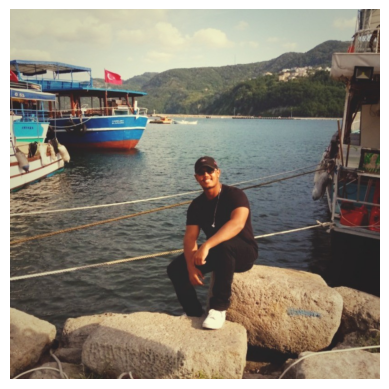

In [24]:

from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("ME.jpeg").convert("RGB")
plt.imshow(img)
plt.axis("off")

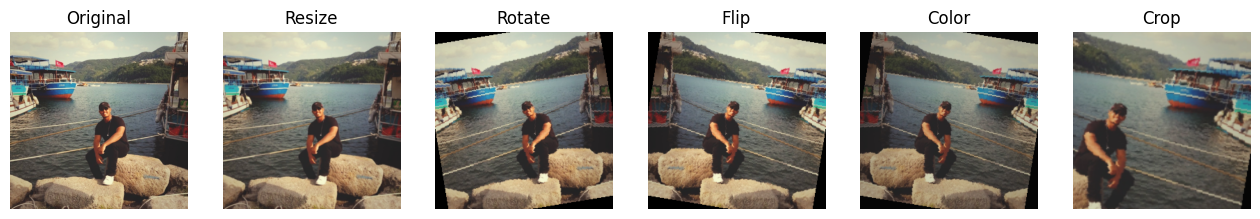

In [26]:
steps = [
    ("Resize", transforms.Resize((256, 256))),
    ("Rotate", transforms.RandomRotation(10)),
    ("Flip", transforms.RandomHorizontalFlip(p=1.0)),
    ("Color", transforms.ColorJitter(0.2, 0.2)),
    ("Crop", transforms.RandomResizedCrop(224, scale=(0.2, 1.0))),
]

fig, axes = plt.subplots(1, len(steps)+1, figsize=(16, 4))
axes[0].imshow(img); axes[0].set_title("Original"); axes[0].axis("off")

current = img
for i, (name, t) in enumerate(steps, 1):
    current = t(current)
    axes[i].imshow(current)
    axes[i].set_title(name)
    axes[i].axis("off")

plt.show()

In [29]:
import tempfile
from pathlib import Path
# Temporary directory for demo
temp_dir = tempfile.mkdtemp()
train_dir = Path(temp_dir) / "train"
val_dir = Path(temp_dir) / "val"

for mode_dir in [train_dir, val_dir]:
    for class_name in ['healthy', 'diseased']:
        class_dir = mode_dir / class_name
        class_dir.mkdir(parents=True, exist_ok=True)
        for i in range(5):  # 5 images per class for demo
            img_array = np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8)
            img = Image.fromarray(img_array)
            img.save(class_dir / f"image_{i}.jpg")

print(f"Temporary dataset created at: {temp_dir}")

Temporary dataset created at: /tmp/tmp7vlku9yr


Loaded 10 images for train set
Classes: {'healthy': 0, 'diseased': 1}
Loaded 10 images for val set
Classes: {'healthy': 0, 'diseased': 1}


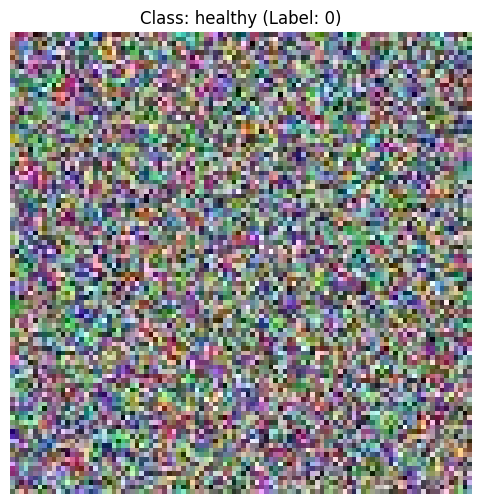

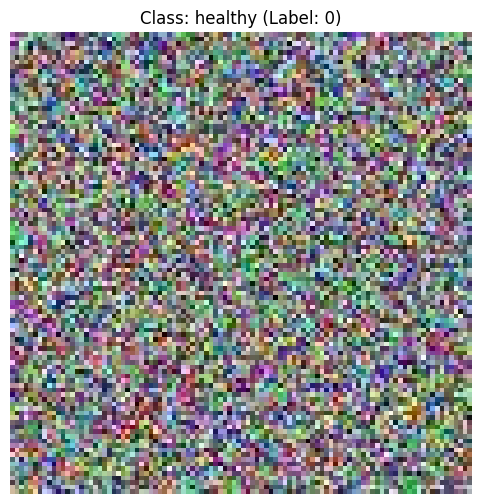

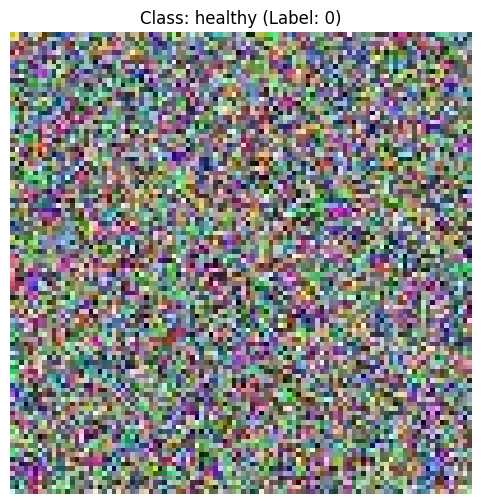

In [32]:
train_dataset = SudanesePlantDataset(root_dir=temp_dir, mode="train")
val_dataset = SudanesePlantDataset(root_dir=temp_dir, mode="val") 

len(train_dataset), len(val_dataset) 

# Display a few training samples
for i in range(3):
    train_dataset.show_sample(i)

In [33]:
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [34]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([8, 3, 224, 224]) torch.Size([8])
